In [25]:
import pandas as pd
df = pd.read_csv('party_speeches_classification_cleaned.csv')

/tmp/ipykernel_28310/2793815192.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('party_speeches_classification_cleaned.csv')


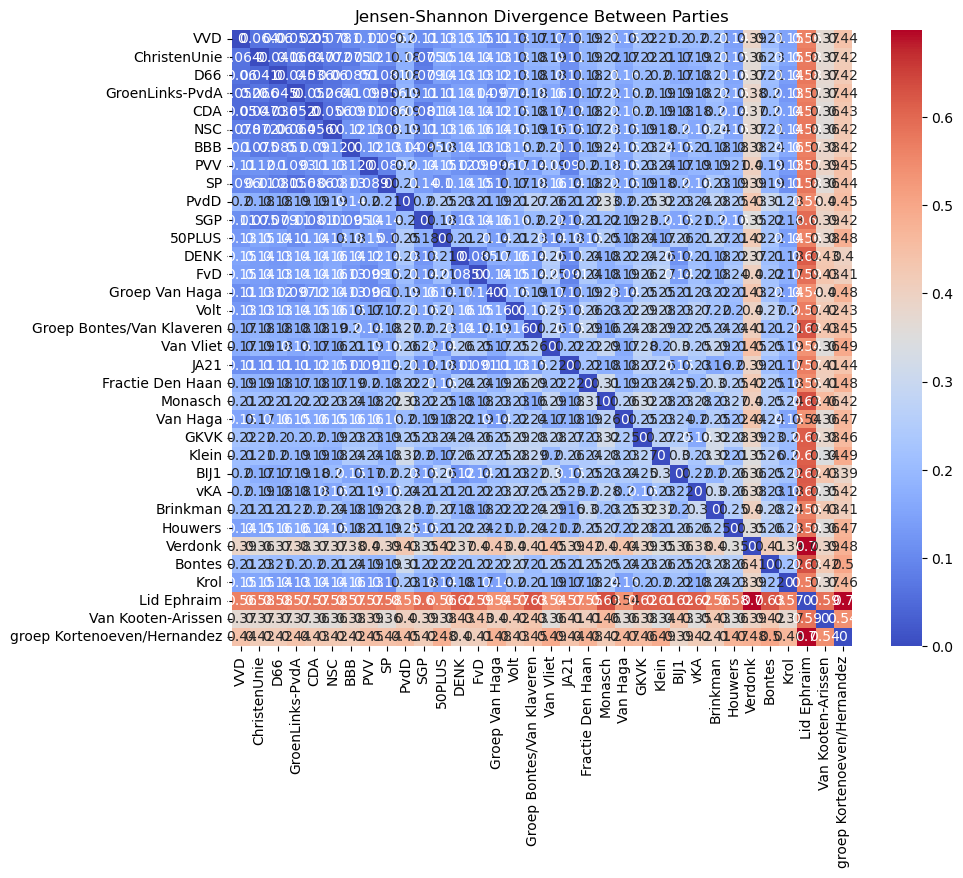

In [26]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows with no party
df = df.dropna(subset=['party'])

# Step 1: Build a topic distribution per speech
def build_topic_dist(row):
    dist = {}
    for i in range(1, 4):
        topic = row[f'top_{i}_topic']
        prob = row[f'top_{i}_prob']
        if isinstance(topic, str) and ' - ' in topic:
            topic_id = topic.split(' - ')[0].strip()
            dist[topic_id] = dist.get(topic_id, 0) + prob
    return dist

df['topic_dist'] = df.apply(build_topic_dist, axis=1)

# Step 2: Aggregate distributions per party
from collections import defaultdict

party_topic_counts = defaultdict(lambda: defaultdict(float))

for _, row in df.iterrows():
    party = row['party']
    for topic, prob in row['topic_dist'].items():
        party_topic_counts[party][topic] += prob

# Get all unique topics
all_topics = sorted({topic for counts in party_topic_counts.values() for topic in counts})

# Step 3: Normalize to probability distributions
party_dists = {}
for party, topic_count in party_topic_counts.items():
    vec = np.array([topic_count.get(topic, 0) for topic in all_topics])
    vec = vec / vec.sum()  # normalize
    party_dists[party] = vec

# Step 4: Compute pairwise Jensen-Shannon divergence
party_names = list(party_dists.keys())
jsd_matrix = pd.DataFrame(index=party_names, columns=party_names, dtype=float)

for p1, p2 in combinations(party_names, 2):
    d1 = party_dists[p1]
    d2 = party_dists[p2]
    jsd = jensenshannon(d1, d2, base=2)
    jsd_matrix.loc[p1, p2] = jsd
    jsd_matrix.loc[p2, p1] = jsd

np.fill_diagonal(jsd_matrix.values, 0.0)

# Optional: Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(jsd_matrix.astype(float), annot=True, cmap="coolwarm")
plt.title("Jensen-Shannon Divergence Between Parties")
plt.show()


/tmp/ipykernel_28310/3706564153.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(jsd_matrix, method='average')


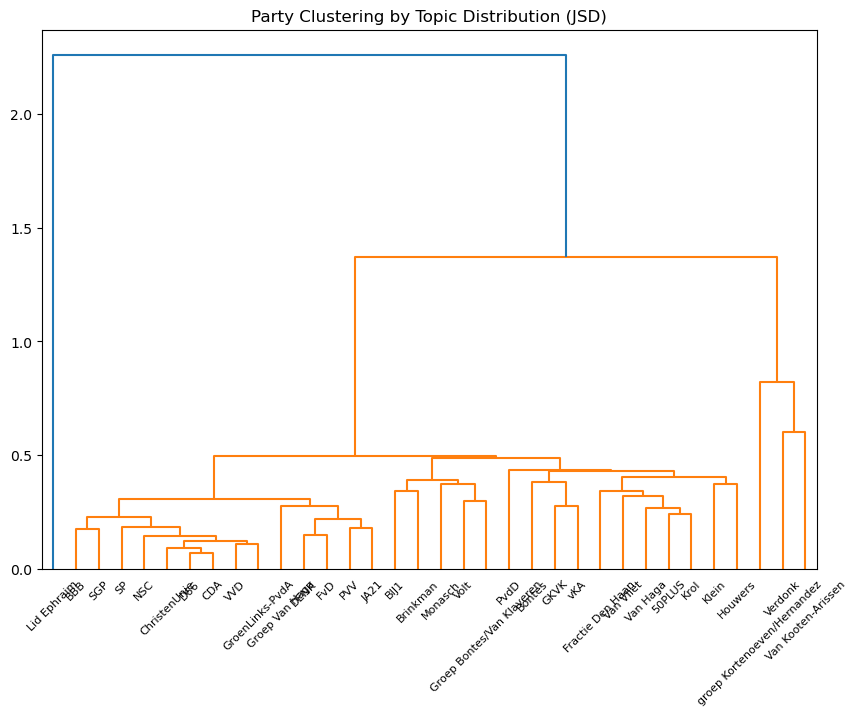

In [27]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

linked = linkage(jsd_matrix, method='average')

plt.figure(figsize=(10, 7))
dendrogram(linked, labels=jsd_matrix.index, orientation='top')
plt.title("Party Clustering by Topic Distribution (JSD)")
plt.show()


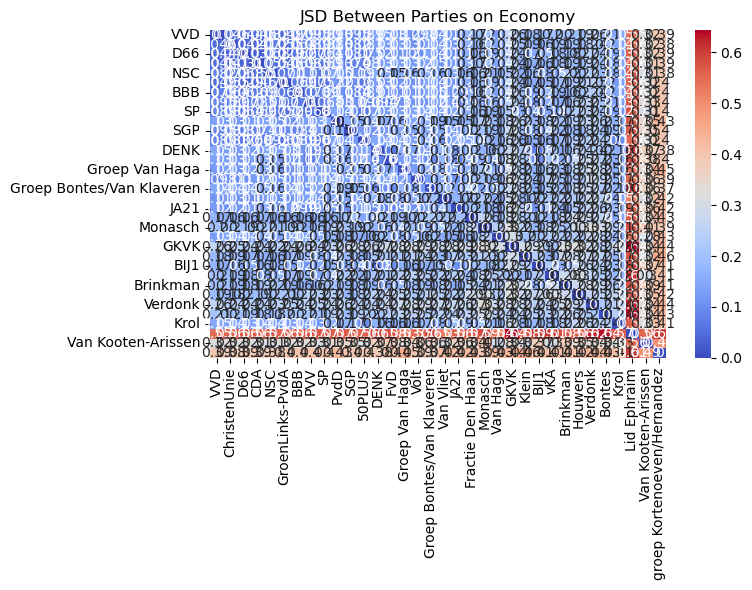

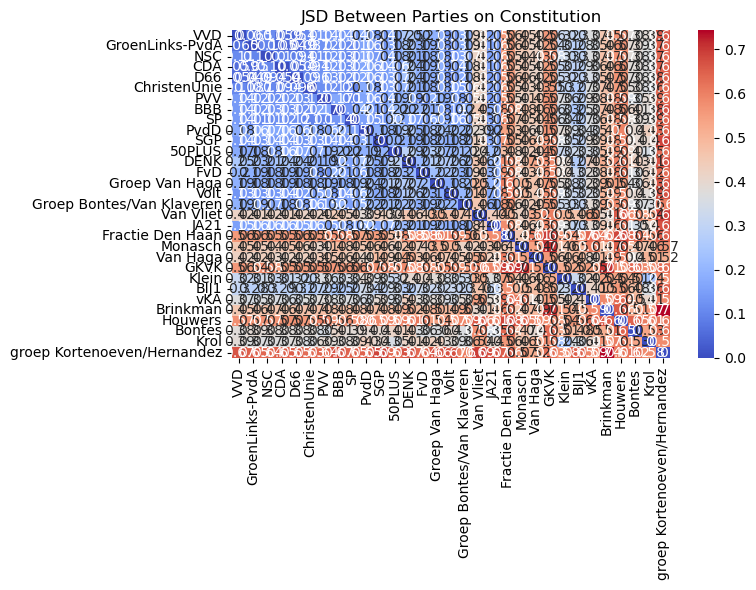

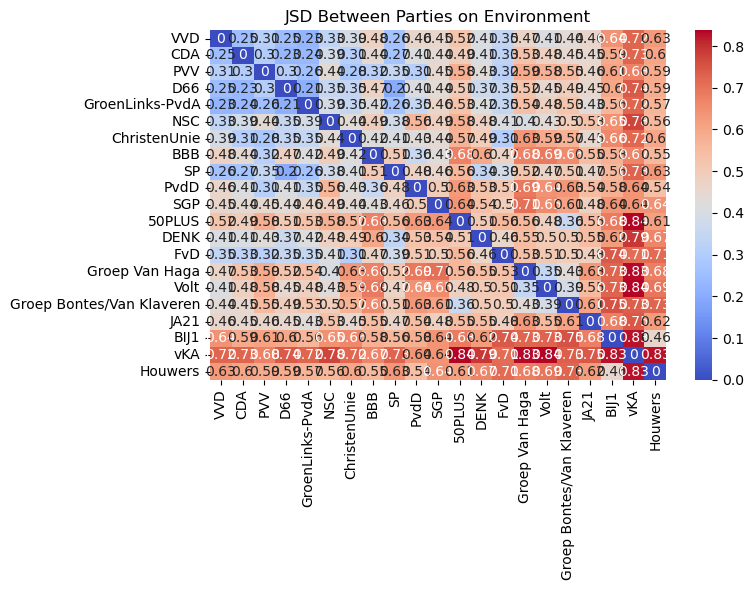

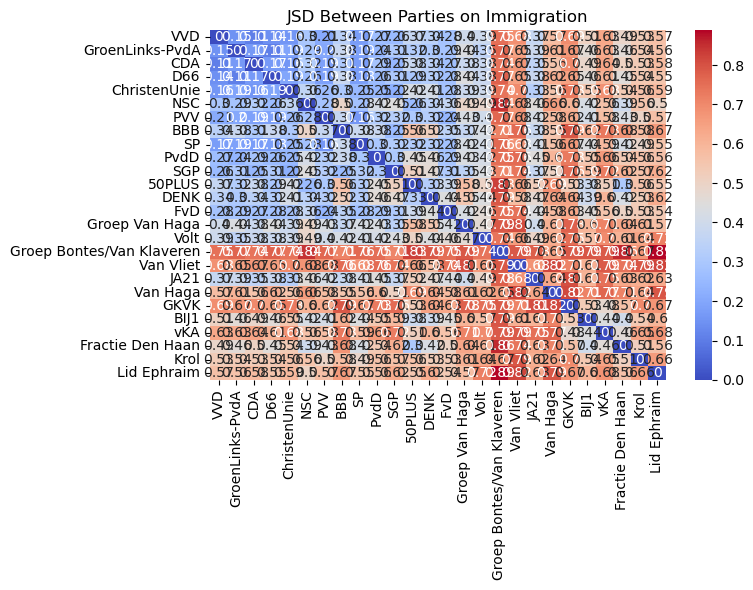

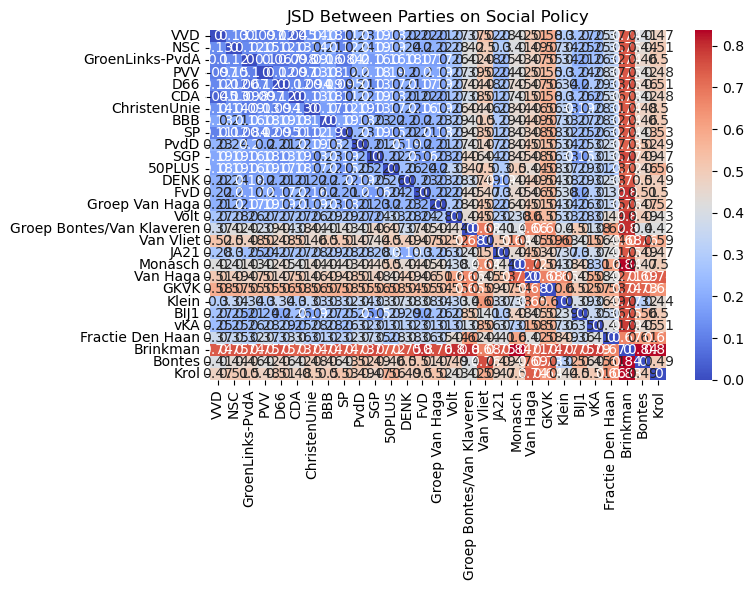

In [28]:
issue_groups = {
    'Economy': {'412', '413', '415'},
    'Constitution': {'203', '204'},
    'Environment': {'601', '602'},
    'Immigration': {'701', '702'},
    'Social Policy': {'501', '502'},
    # Add more based on your full topic list
}


def get_issues_for_speech(row, issue_groups):
    issues = set()
    for i in range(1, 4):
        topic = row.get(f'top_{i}_topic', '')
        if isinstance(topic, str) and ' - ' in topic:
            topic_id = topic.split(' - ')[0].strip()
            for issue, topic_ids in issue_groups.items():
                if topic_id in topic_ids:
                    issues.add(issue)
    return list(issues)

df['issues'] = df.apply(get_issues_for_speech, axis=1, issue_groups=issue_groups)


from collections import defaultdict
from scipy.spatial.distance import jensenshannon
import pandas as pd
import numpy as np

issue_jsd_results = {}

for issue in issue_groups.keys():
    subset = df[df['issues'].apply(lambda x: issue in x)]
    if subset.empty:
        continue

    # Aggregate topic distributions per party
    party_topic_counts = defaultdict(lambda: defaultdict(float))
    
    for _, row in subset.iterrows():
        party = row['party']
        if pd.isna(party):
            continue
        for topic, prob in row['topic_dist'].items():
            party_topic_counts[party][topic] += prob

    all_topics = sorted({topic for counts in party_topic_counts.values() for topic in counts})

    party_dists = {}
    for party, topic_count in party_topic_counts.items():
        vec = np.array([topic_count.get(topic, 0) for topic in all_topics])
        if vec.sum() == 0:
            continue
        vec = vec / vec.sum()
        party_dists[party] = vec

    party_names = list(party_dists.keys())
    jsd_matrix = pd.DataFrame(index=party_names, columns=party_names, dtype=float)

    for p1 in party_names:
        for p2 in party_names:
            if p1 == p2:
                jsd = 0.0
            else:
                jsd = jensenshannon(party_dists[p1], party_dists[p2], base=2)
            jsd_matrix.loc[p1, p2] = jsd

    issue_jsd_results[issue] = jsd_matrix



import seaborn as sns
import matplotlib.pyplot as plt

for issue, matrix in issue_jsd_results.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix.astype(float), annot=True, cmap='coolwarm')
    plt.title(f"JSD Between Parties on {issue}")
    plt.tight_layout()
    plt.show()



In [29]:
from sklearn.manifold import MDS

# Use the full JSD matrix (e.g., from earlier)
mds = MDS(n_components=1, dissimilarity='precomputed', random_state=42)
ideology_scores = mds.fit_transform(jsd_matrix.values)

# Attach scores to party names
ideology_df = pd.DataFrame({'party': jsd_matrix.index, 'ideology_score': ideology_scores.flatten()})
ideology_df = ideology_df.sort_values(by='ideology_score').reset_index(drop=True)
print(ideology_df)


                        party  ideology_score
0                    Brinkman       -0.730314
1                        GKVK       -0.510419
2                     Monasch       -0.362132
3                      Bontes       -0.351043
4            Fractie Den Haan       -0.239087
5              Groep Van Haga       -0.130199
6                         SGP       -0.094550
7                         FvD       -0.092813
8                         VVD       -0.057058
9                          SP       -0.055348
10                        PVV       -0.044581
11               ChristenUnie       -0.034285
12                        NSC       -0.031420
13                        vKA       -0.022627
14                        CDA       -0.003237
15            GroenLinks-PvdA        0.005754
16                        D66        0.010049
17                        BBB        0.043988
18                     50PLUS        0.045772
19                       BIJ1        0.092558
20                       DENK     

In [30]:
issue_leaning = {
    'Economy': +1,           # right-leaning
    'Constitution': 0,       # neutral
    'Environment': -1,       # left
    'Immigration': +1,       # right
    'Social Policy': -1      # left
}


party_scores = defaultdict(list)

for issue, jsd_mat in issue_jsd_results.items():
    if issue not in issue_leaning:
        continue
    lean = issue_leaning[issue]
    avg_dists = jsd_mat.mean(axis=1)
    for party, dist in avg_dists.items():
        party_scores[party].append(lean * (1 - dist))  # closer = more aligned

# Final ideological score per party
ideology_scores = {party: np.mean(scores) for party, scores in party_scores.items()}
ideology_df = pd.DataFrame.from_dict(ideology_scores, orient='index', columns=['ideology_score']).sort_values(by='ideology_score')
print(ideology_df)


                             ideology_score
Groep Bontes/Van Klaveren          0.008154
GroenLinks-PvdA                    0.027306
CDA                                0.029727
VVD                                0.029829
D66                                0.029939
NSC                                0.030613
PVV                                0.031699
SP                                 0.032659
DENK                               0.033751
FvD                                0.033759
Groep Van Haga                     0.034206
BBB                                0.034212
PvdD                               0.034488
ChristenUnie                       0.034656
JA21                               0.036254
Volt                               0.037910
SGP                                0.039115
vKA                                0.045556
BIJ1                               0.048001
50PLUS                             0.049412
Klein                              0.054589
Monasch                         

In [33]:
issue_leaning = {
    'Economy': +1,           # traditionally right
    'Constitution': 0,       # neutral
    'Environment': -1,       # traditionally left
    'Immigration': +1,       # traditionally right
    'Social Policy': -1      # traditionally left
}


from collections import defaultdict
import pandas as pd
import numpy as np

issue_party_scores = {}

for issue, topic_ids in issue_groups.items():
    subset = df[df['issues'].apply(lambda x: issue in x)]
    if subset.empty:
        continue

    # Aggregate topic distributions per party
    party_topic_counts = defaultdict(lambda: defaultdict(float))
    
    for _, row in subset.iterrows():
        party = row['party']
        if pd.isna(party):
            continue
        for topic, prob in row['topic_dist'].items():
            if topic in topic_ids:
                party_topic_counts[party][topic] += prob

    # Normalize per party
    party_dists = {}
    for party, topic_count in party_topic_counts.items():
        vec = np.array([topic_count.get(t, 0) for t in topic_ids])
        if vec.sum() == 0:
            continue
        vec = vec / vec.sum()
        party_dists[party] = vec

    # Compute mean usage for each party (as proxy for alignment)
    issue_scores = {}
    max_val = 0
    for party, vec in party_dists.items():
        score = vec.sum()  # total emphasis on this issue
        issue_scores[party] = score
        max_val = max(max_val, score)

    # Normalize & apply ideological direction
    if max_val > 0:
        for party in issue_scores:
            norm_score = issue_scores[party] / max_val
            issue_scores[party] = norm_score * issue_leaning.get(issue, 0)

    issue_party_scores[issue] = issue_scores



# Combine into a DataFrame
issue_score_df = pd.DataFrame(issue_party_scores).fillna(0).round(2)
issue_score_df = issue_score_df.sort_index()
print(issue_score_df)


                             Economy  Constitution  Environment  Immigration  \
50PLUS                           1.0           0.0         -1.0          1.0   
BBB                              1.0           0.0         -1.0          1.0   
BIJ1                             1.0           0.0         -1.0          1.0   
Bontes                           1.0           0.0          0.0          0.0   
Brinkman                         1.0           0.0          0.0          0.0   
CDA                              1.0           0.0         -1.0          1.0   
ChristenUnie                     1.0           0.0         -1.0          1.0   
D66                              1.0           0.0         -1.0          1.0   
DENK                             1.0           0.0         -1.0          1.0   
Fractie Den Haan                 1.0           0.0          0.0          1.0   
FvD                              1.0           0.0         -1.0          1.0   
GKVK                             1.0    

In [34]:
from collections import defaultdict
import numpy as np
import pandas as pd

# Define which topics belong to which ideological issue
issue_groups = {
    'Economy': {'412', '413', '415'},
    'Constitution': {'203', '204'},
    'Environment': {'601', '602'},
    'Immigration': {'701', '702'},
    'Social Policy': {'501', '502'},
}

# Define the leaning of each issue
issue_leaning = {
    'Economy': +1,           # traditionally right
    'Constitution': 0,       # neutral
    'Environment': -1,       # traditionally left
    'Immigration': +1,       # traditionally right
    'Social Policy': -1      # traditionally left
}

# Step 1: Aggregate topic probabilities per party per issue
party_issue_strengths = defaultdict(lambda: defaultdict(float))

for _, row in df.iterrows():
    party = row['party']
    if pd.isna(party):
        continue
    topic_dist = row['topic_dist']
    for topic_id, prob in topic_dist.items():
        for issue, issue_topic_ids in issue_groups.items():
            if topic_id in issue_topic_ids:
                party_issue_strengths[party][issue] += prob

# Step 2: Normalize scores per issue (not per party) and apply leaning
issue_party_scores = defaultdict(dict)

for issue in issue_groups:
    # Get raw scores for this issue
    raw_scores = {party: party_issue_strengths[party].get(issue, 0.0)
                  for party in party_issue_strengths}
    max_val = max(raw_scores.values()) if raw_scores else 1.0

    for party, score in raw_scores.items():
        normalized = score / max_val if max_val > 0 else 0
        ideological_score = normalized * issue_leaning.get(issue, 0)
        issue_party_scores[party][issue] = ideological_score

# Step 3: Convert to DataFrame
issue_score_df = pd.DataFrame(issue_party_scores).T.fillna(0).round(2)
issue_score_df = issue_score_df.sort_index()
print(issue_score_df)


                             Economy  Constitution  Environment  Immigration  \
50PLUS                          0.06           0.0        -0.01         0.09   
BBB                             0.07           0.0        -0.07         0.14   
BIJ1                            0.01           0.0        -0.01         0.01   
Bontes                          0.00           0.0        -0.00         0.00   
Brinkman                        0.00           0.0        -0.00         0.00   
CDA                             0.72           0.0        -0.60         0.73   
ChristenUnie                    0.34           0.0        -0.15         0.39   
D66                             0.74           0.0        -0.60         0.75   
DENK                            0.10           0.0        -0.10         0.07   
Fractie Den Haan                0.01           0.0        -0.00         0.03   
FvD                             0.07           0.0        -0.13         0.10   
GKVK                            0.00    

# Mapping of the ideological scores using the manifestoberta topics

In [35]:
ideology_dimensions = {
    'Economic_Left_Right': {
        'left': ['412', '413', '415', '504', '409', '503'],
        'right': ['401', '402', '404', '505', '414'],
    },
    'Cultural_Progressive_Conservative': {
        'left': ['604', '607', '705', '706', '503'],
        'right': ['603', '601', '605', '606'],
    },
    'Globalist_Nationalist': {
        'left': ['107', '108', '101', '106'],
        'right': ['109', '110', '102', '104'],
    },
    'Libertarian_Authoritarian': {
        'left': ['201', '202', '604'],
        'right': ['603', '601', '605'],
    }
}


/tmp/ipykernel_28310/1259602518.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(parties))


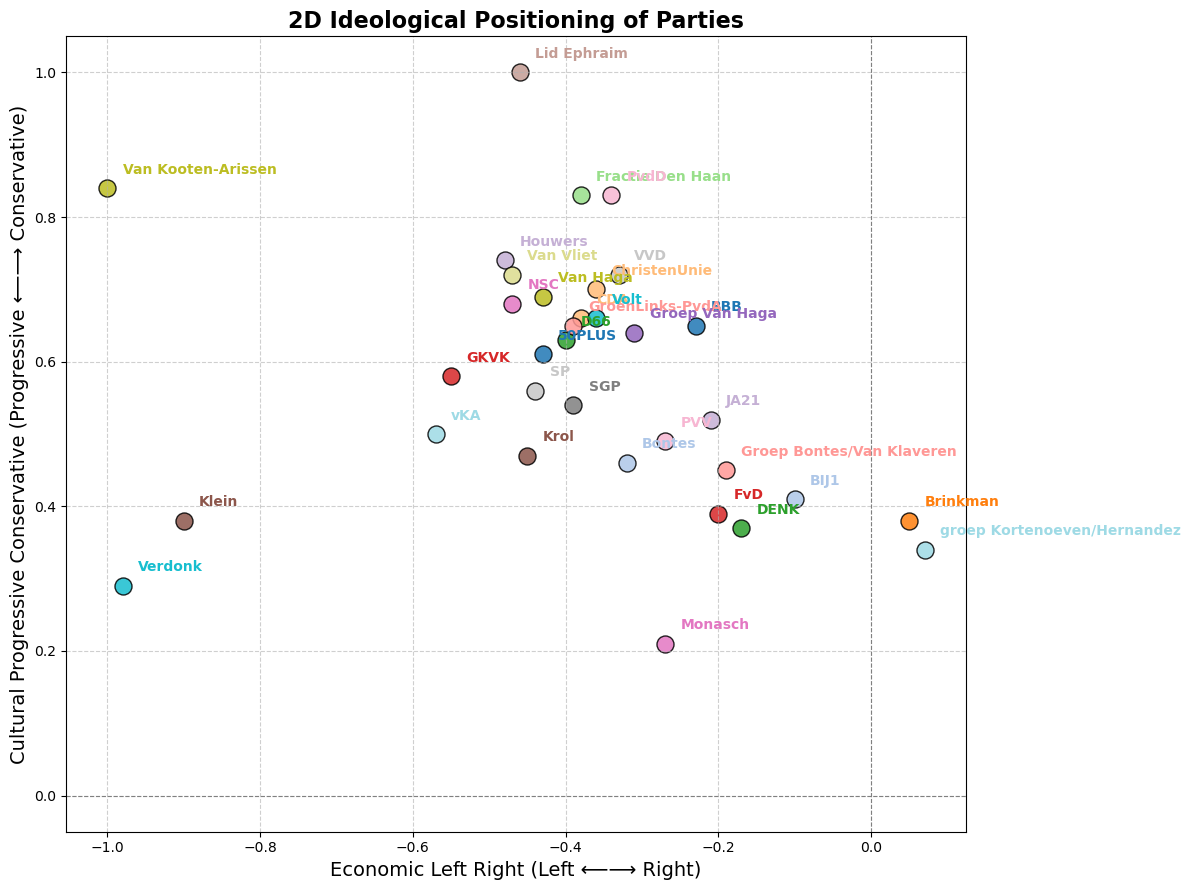

In [46]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

ideology_dimensions = {
    'Economic_Left_Right': {
        'left': ['412', '413', '415', '504', '409', '503'],
        'right': ['401', '402', '404', '505', '414'],
    },
    'Cultural_Progressive_Conservative': {
        'left': ['604', '607', '705', '706', '503'],
        'right': ['603', '601', '605', '606'],
    },
    'Globalist_Nationalist': {
        'left': ['107', '108', '101', '106'],
        'right': ['109', '110', '102', '104'],
    },
    'Libertarian_Authoritarian': {
        'left': ['201', '202', '604'],
        'right': ['603', '601', '605'],
    }
}

# Accumulate sums and counts to later average
party_scores = defaultdict(lambda: defaultdict(float))
party_counts = defaultdict(int)

for _, row in df.iterrows():
    party = row.get('party')
    topic_dist = row.get('topic_dist')
    
    if pd.isna(party) or not isinstance(topic_dist, dict):
        continue
    
    party_counts[party] += 1
    
    for dim, sides in ideology_dimensions.items():
        left_score = sum(topic_dist.get(str(t), 0) for t in sides['left'])
        right_score = sum(topic_dist.get(str(t), 0) for t in sides['right'])
        party_scores[party][dim] += (right_score - left_score)

# Average scores per party
for party in party_scores:
    count = party_counts[party] if party_counts[party] > 0 else 1
    for dim in ideology_dimensions:
        party_scores[party][dim] /= count

# Normalize scores to [-1, 1] per dimension
normalized_scores = defaultdict(dict)
for dim in ideology_dimensions:
    scores = [abs(party_scores[party][dim]) for party in party_scores]
    max_abs = max(scores) if scores else 1
    for party in party_scores:
        normalized_scores[party][dim] = round(party_scores[party][dim] / max_abs, 2) if max_abs > 0 else 0

# Create DataFrame
ideology_df = pd.DataFrame(normalized_scores).T.sort_index()

# Plotting
x_dim = 'Economic_Left_Right'
y_dim = 'Cultural_Progressive_Conservative'

plt.figure(figsize=(12, 9))
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

parties = ideology_df.index.tolist()
colors = plt.cm.get_cmap('tab20', len(parties))
party_color_map = {party: colors(i) for i, party in enumerate(parties)}

for party, row in ideology_df.iterrows():
    x = row.get(x_dim, 0)
    y = row.get(y_dim, 0)
    plt.scatter(x, y, s=150, color=party_color_map[party], edgecolors='black', alpha=0.85)
    plt.text(x + 0.02, y + 0.02, party, fontsize=10, fontweight='bold', color=party_color_map[party])

plt.xlabel(f"{x_dim.replace('_', ' ')} (Left ⟵⟶ Right)", fontsize=14)
plt.ylabel(f"{y_dim.replace('_', ' ')} (Progressive ⟵⟶ Conservative)", fontsize=14)
plt.title("2D Ideological Positioning of Parties", fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


/tmp/ipykernel_28310/407735257.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(parties))


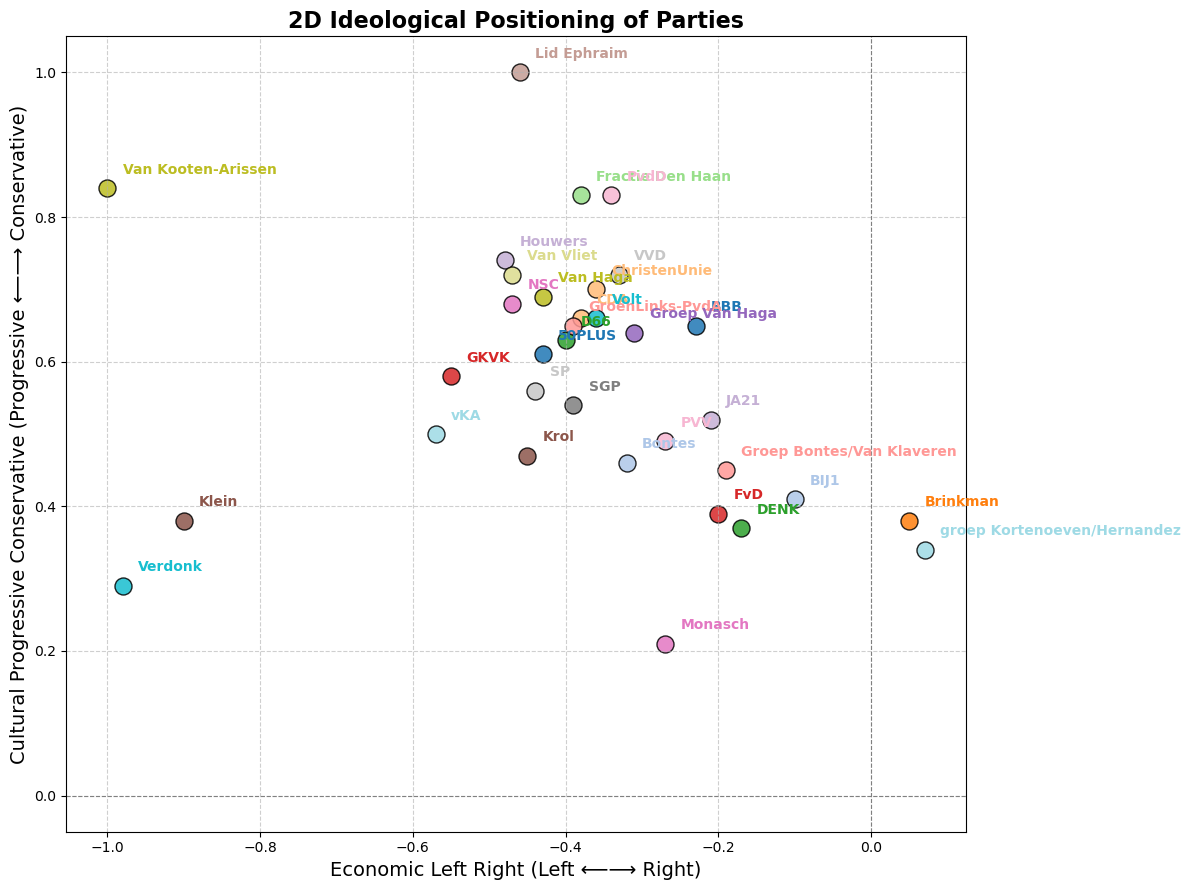

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# ideology_dimensions is assumed defined as before

party_scores = defaultdict(lambda: defaultdict(float))
party_counts = defaultdict(int)

for _, row in df.iterrows():
    party = row.get('party')
    topic_dist = row.get('topic_dist')
    
    if pd.isna(party) or not isinstance(topic_dist, dict):
        continue
    
    party_counts[party] += 1
    
    for dim, sides in ideology_dimensions.items():
        # Convert topic IDs to strings to match keys
        left_score = sum(topic_dist.get(str(t), 0) for t in sides['left'])
        right_score = sum(topic_dist.get(str(t), 0) for t in sides['right'])
        party_scores[party][dim] += (right_score - left_score)

# Average per party
for party in party_scores:
    count = party_counts[party] if party_counts[party] > 0 else 1
    for dim in ideology_dimensions:
        party_scores[party][dim] /= count

# Normalize to [-1, 1]
normalized_scores = defaultdict(dict)
for dim in ideology_dimensions:
    scores = [abs(party_scores[party][dim]) for party in party_scores]
    max_abs = max(scores) if scores else 1
    for party in party_scores:
        normalized_scores[party][dim] = round(party_scores[party][dim] / max_abs, 2) if max_abs > 0 else 0

ideology_df = pd.DataFrame(normalized_scores).T.sort_index()

# === Plotting ===
x_dim = 'Economic_Left_Right'
y_dim = 'Cultural_Progressive_Conservative'

plt.figure(figsize=(12, 9))
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

parties = ideology_df.index.tolist()
colors = plt.cm.get_cmap('tab20', len(parties))
party_color_map = {party: colors(i) for i, party in enumerate(parties)}

for party, row in ideology_df.iterrows():
    x = row.get(x_dim, 0)
    y = row.get(y_dim, 0)
    plt.scatter(x, y, s=150, color=party_color_map[party], edgecolors='black', alpha=0.85)
    plt.text(x + 0.02, y + 0.02, party, fontsize=10, fontweight='bold', color=party_color_map[party])

plt.xlabel(f"{x_dim.replace('_', ' ')} (Left ⟵⟶ Right)", fontsize=14)
plt.ylabel(f"{y_dim.replace('_', ' ')} (Progressive ⟵⟶ Conservative)", fontsize=14)
plt.title("2D Ideological Positioning of Parties", fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [47]:

ideology_df = pd.DataFrame(normalized_scores).T.sort_index()

# Save to CSV
ideology_df.to_csv('party_ideology_scores.csv')

print("Ideology scores saved to party_ideology_scores.csv")


Ideology scores saved to party_ideology_scores.csv


In [49]:
import numpy as np
from scipy.spatial.distance import jensenshannon

def jensen_shannon_divergence(p, q):
    # Ensure numpy arrays and normalized
    p = np.array(p)
    q = np.array(q)
    p = p / p.sum()
    q = q / q.sum()
    return jensenshannon(p, q)**2  # scipy returns sqrt(JS), square it for divergence


In [50]:
from collections import defaultdict
import pandas as pd

# Collect topic vectors per party
party_topic_vecs = defaultdict(list)

# Assuming df['topic_dist'] is dict {topic_id_str: score}, scores sum to 1 per row or close
all_topics = set()
for _, row in df.iterrows():
    party = row.get('party')
    topic_dist = row.get('topic_dist')
    if pd.isna(party) or not isinstance(topic_dist, dict):
        continue
    party_topic_vecs[party].append(topic_dist)
    all_topics.update(topic_dist.keys())

all_topics = sorted(all_topics)  # fix order for vectorization

# Average topic distribution per party
avg_party_dist = {}
for party, dist_list in party_topic_vecs.items():
    # Create matrix: rows=documents, columns=topics
    mat = np.zeros((len(dist_list), len(all_topics)))
    for i, dist in enumerate(dist_list):
        for j, topic in enumerate(all_topics):
            mat[i, j] = dist.get(topic, 0)
    avg = mat.mean(axis=0)
    avg /= avg.sum()  # normalize to sum=1
    avg_party_dist[party] = avg


In [51]:
parties = sorted(avg_party_dist.keys())
n = len(parties)
jsd_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i == j:
            jsd_matrix[i, j] = 0
        elif i < j:
            jsd = jensen_shannon_divergence(avg_party_dist[parties[i]], avg_party_dist[parties[j]])
            jsd_matrix[i, j] = jsd
            jsd_matrix[j, i] = jsd


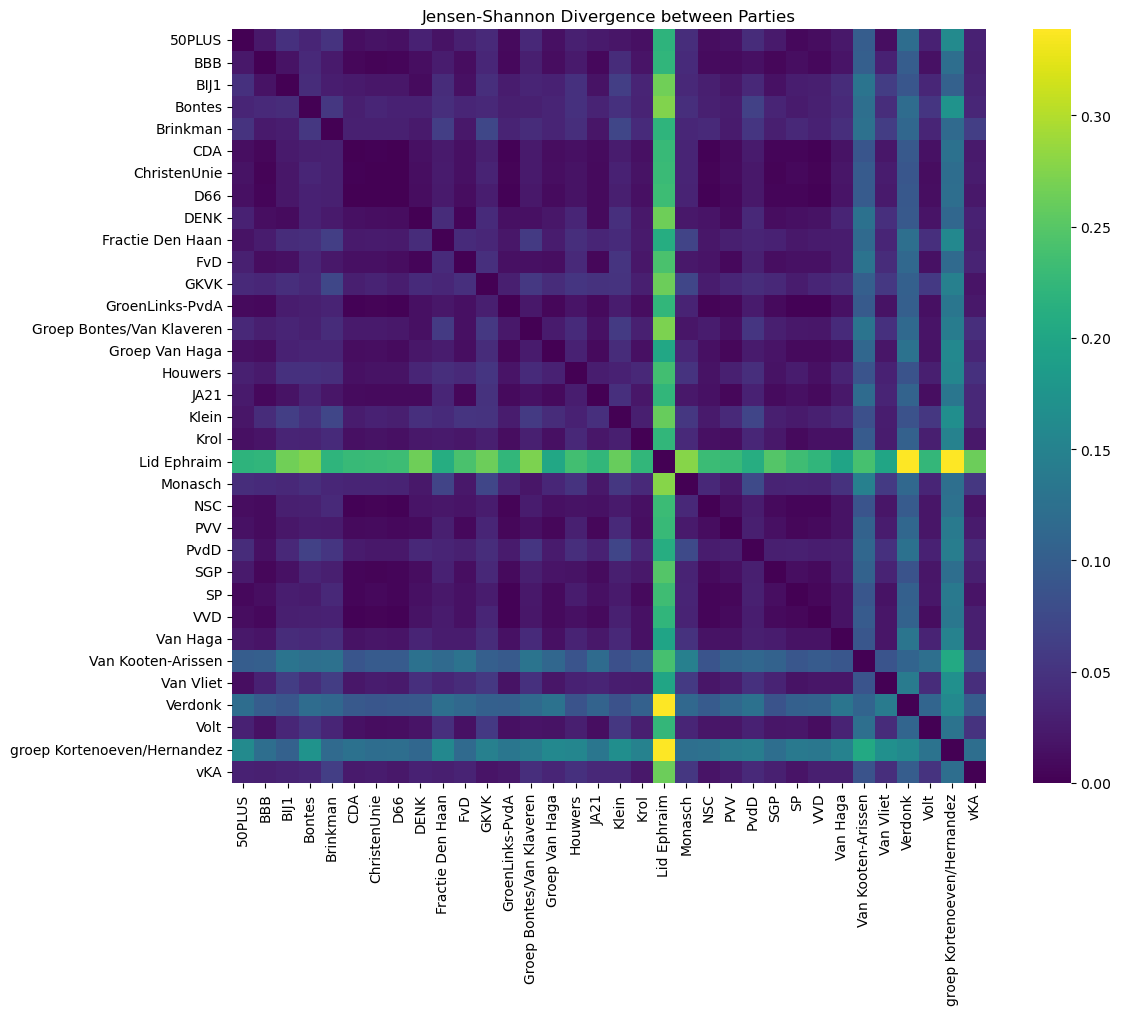

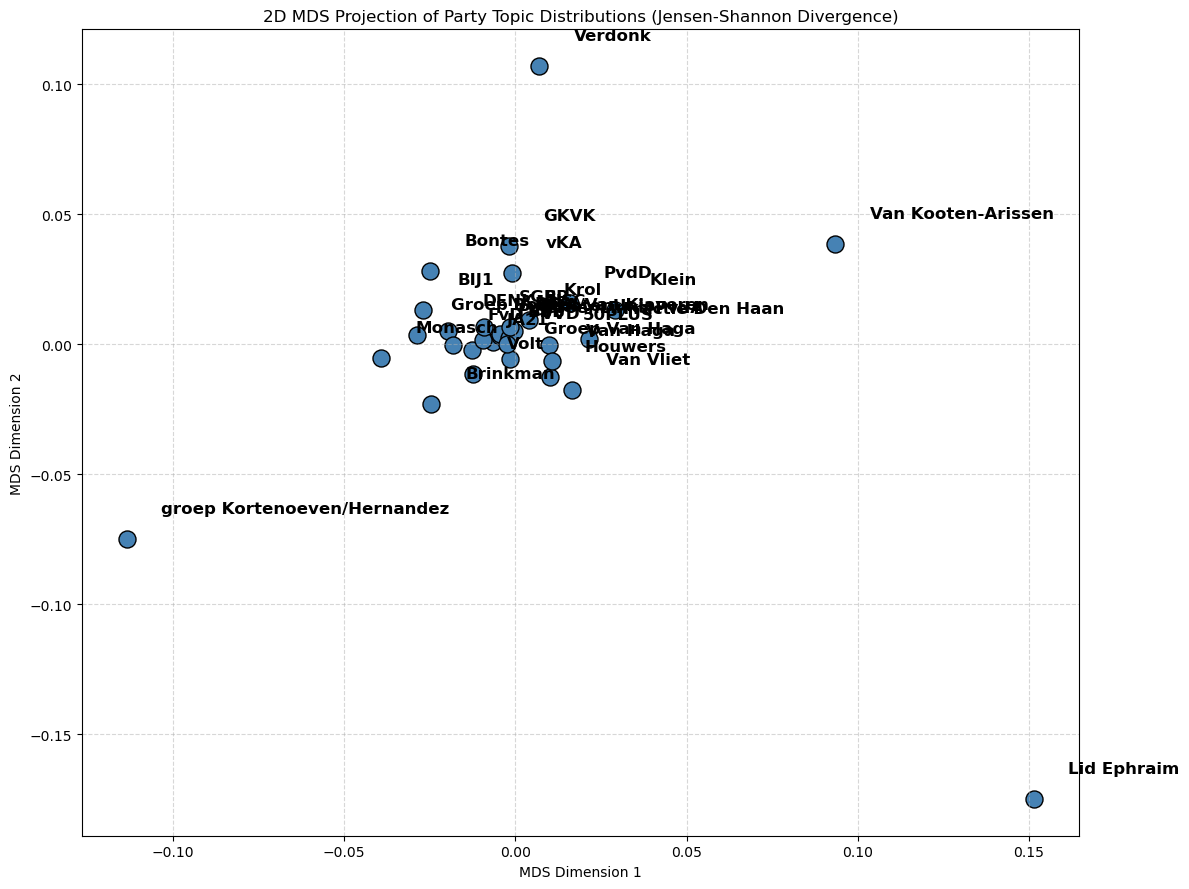

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS

# Heatmap of JSD matrix
plt.figure(figsize=(12, 10))
sns.heatmap(jsd_matrix, xticklabels=parties, yticklabels=parties, cmap='viridis', square=True)
plt.title("Jensen-Shannon Divergence between Parties")
plt.tight_layout()
plt.show()

# MDS 2D plot of ideological distances
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(jsd_matrix)

plt.figure(figsize=(12, 9))
plt.scatter(coords[:, 0], coords[:, 1], s=150, color='steelblue', edgecolors='black')
for i, party in enumerate(parties):
    plt.text(coords[i, 0] + 0.01, coords[i, 1] + 0.01, party, fontsize=12, fontweight='bold')
plt.title("2D MDS Projection of Party Topic Distributions (Jensen-Shannon Divergence)")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
